In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:.2f}".format
pd.options.display.max_columns = 40

### Game Analysis

In [2]:
df_game = pd.read_csv('E:\COM480-DataVis\datavis-project-2022-y3\Data\match_results.csv', 
                      parse_dates=['date'],
                      usecols=['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament'])
df_game.head()

,date,home_team,away_team,home_score,away_score,tournament
0,1872-11-30,Scotland,England,0,0,Friendly
1,1873-03-08,England,Scotland,4,2,Friendly
2,1874-03-07,Scotland,England,2,1,Friendly
3,1875-03-06,England,Scotland,2,2,Friendly
4,1876-03-04,Scotland,England,3,0,Friendly


First thing first, we are going to filter the dataframe by year of which matches were held, as well as tournament that are methods of qualifaction toward FIFA world cup, or just world cup games. To be specific, we only keep games took place after 1990 that were part of the following tournaments:
- AFC Asian Cup
- AFC Asian Cup qualification
- African Cup of Nations
- African Cup of Nations qualification
- Copa América
- Copa América qualification
- FIFA World Cup
- FIFA World Cup qualification
- Oceania Nations Cup
- UEFA Euro
- UEFA Euro qualification
- UEFA Nations League


In [3]:
# Filter data by year and tournament

# Only keep games from 1990
df_game = df_game[df_game.date.dt.year >= 1990]

# Only keep tournament that are methods of qualifaction for world cup, that is:
tournaments=['AFC Asian Cup', 'AFC Asian Cup qualification', 'African Cup of Nations', 'African Cup of Nations qualification', 'Copa América', 'Copa América qualification'
             'FIFA World Cup', 'FIFA World Cup qualification', 'Oceania Nations Cup', 'UEFA Euro', 'UEFA Euro qualification', 'UEFA Nations League']

df_game = df_game[df_game.tournament.isin(tournaments)]
df_game.head()

,date,home_team,away_team,home_score,away_score,tournament
16061,1990-03-02,Algeria,Nigeria,5,1,African Cup of Nations
16062,1990-03-03,Cameroon,Zambia,0,1,African Cup of Nations
16063,1990-03-03,Ivory Coast,Egypt,3,1,African Cup of Nations
16064,1990-03-03,Senegal,Kenya,0,0,African Cup of Nations
16066,1990-03-05,Algeria,Ivory Coast,3,0,African Cup of Nations


In [4]:
# One-hot Encoding on result of the match

# In football matches on a home-and-away basis, draw is equivalent to away team win
df_game['result'] = df_game.apply(lambda Row: 'home_win' if Row['home_score'] > Row['away_score'] else 'away_win', axis=1)

# One-hot Encoding
df_game = pd.get_dummies(df_game, columns=['result'])
df_game.head()

,date,home_team,away_team,home_score,away_score,tournament,result_away_win,result_home_win
16061,1990-03-02,Algeria,Nigeria,5,1,African Cup of Nations,0,1
16062,1990-03-03,Cameroon,Zambia,0,1,African Cup of Nations,1,0
16063,1990-03-03,Ivory Coast,Egypt,3,1,African Cup of Nations,0,1
16064,1990-03-03,Senegal,Kenya,0,0,African Cup of Nations,1,0
16066,1990-03-05,Algeria,Ivory Coast,3,0,African Cup of Nations,0,1


In [5]:
# Calculate goal difference

df_game["goal_diff"] = df_game.home_score - df_game.away_score
df_game["home_goal_diff"] = df_game.apply(lambda Row: Row['goal_diff'] if Row['goal_diff'] > 0 else 0, axis=1)
df_game["away_goal_diff"] = df_game.apply(lambda Row: -Row['goal_diff'] if Row['goal_diff'] <= 0 else 0, axis=1)
df_game.drop(['goal_diff'], axis=1, inplace=True)

In [6]:
df_game

,date,home_team,away_team,home_score,away_score,tournament,result_away_win,result_home_win,home_goal_diff,away_goal_diff
16061,1990-03-02,Algeria,Nigeria,5,1,African Cup of Nations,0,1,4,0
16062,1990-03-03,Cameroon,Zambia,0,1,African Cup of Nations,1,0,0,1
16063,1990-03-03,Ivory Coast,Egypt,3,1,African Cup of Nations,0,1,2,0
16064,1990-03-03,Senegal,Kenya,0,0,African Cup of Nations,1,0,0,0
16066,1990-03-05,Algeria,Ivory Coast,3,0,African Cup of Nations,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...
43178,2022-01-30,Senegal,Equatorial Guinea,3,1,African Cup of Nations,0,1,2,0
43184,2022-02-02,Burkina Faso,Senegal,1,3,African Cup of Nations,1,0,0,2
43185,2022-02-03,Cameroon,Egypt,0,0,African Cup of Nations,1,0,0,0
43186,2022-02-05,Cameroon,Burkina Faso,3,3,African Cup of Nations,1,0,0,0


In [7]:
# Gather statistics: number of win and lose matches as home team and away team respectively, as well as total

df_home_count = df_game.groupby('home_team').agg({'result_home_win': 'sum', 'away_team': 'count', 'home_score': 'sum', 'home_goal_diff': 'sum'})\
                                            .rename(columns={'result_home_win':'home_win', 'away_team': 'home_count'}).reset_index()

df_away_count = df_game.groupby('away_team').agg({'result_away_win': 'sum', 'home_team': 'count', 'away_score': 'sum', 'away_goal_diff': 'sum'})\
                                            .rename(columns={'result_away_win':'away_win', 'home_team': 'away_count'}).reset_index()

df_game_stat = df_home_count.merge(df_away_count, left_on='home_team', right_on='away_team', how='inner').drop(['away_team'], axis=1)
df_game_stat.rename(columns={'home_team':'team'}, inplace=True)

df_game_stat['total_count'] = df_game_stat.home_count + df_game_stat.away_count
df_game_stat['total_win']   = df_game_stat.home_win + df_game_stat.away_win
df_game_stat['total_score'] = df_game_stat.home_score + df_game_stat.away_score

df_game_stat['home_lose']  = df_game_stat.home_count - df_game_stat.home_win
df_game_stat['away_lose']  = df_game_stat.away_count - df_game_stat.away_win
df_game_stat['total_lose'] = df_game_stat.home_lose + df_game_stat.away_lose

# Win rate statistics
df_game_stat['home_win_rate']   = df_game_stat.home_win / df_game_stat.home_count
df_game_stat['away_win_rate']   = df_game_stat.away_win / df_game_stat.away_count
df_game_stat['total_win_rate']  = df_game_stat.total_win / df_game_stat.total_count

# Goal difference statistics
df_game_stat['avg_home_goal_diff']  = df_game_stat.home_goal_diff / df_game_stat.home_win
df_game_stat['avg_away_goal_diff']  = df_game_stat.away_goal_diff / df_game_stat.away_win
df_game_stat['total_goal_diff']     = df_game_stat.home_goal_diff + df_game_stat.away_goal_diff
df_game_stat['avg_total_goal_diff'] = df_game_stat.total_goal_diff / df_game_stat.total_win

# Fill 0 for teams with 0 home_win and/or away_win count 
df_game_stat = df_game_stat.fillna(0)
df_game_stat.head()

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,total_win,total_score,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
0,Afghanistan,4,14,15,6,6,16,9,2,30,10,24,10,10,20,0.29,0.38,0.33,1.50,0.33,8,0.80
1,Albania,28,84,90,45,31,86,62,32,170,59,152,56,55,111,0.33,0.36,0.35,1.61,1.03,77,1.31
2,Algeria,59,89,193,146,57,98,104,46,187,116,297,30,41,71,0.66,0.58,0.62,2.47,0.81,192,1.66
3,American Samoa,0,4,1,0,0,4,0,0,8,0,1,4,4,8,0.00,0.00,0.00,0.00,0.00,0,0.00
4,Andorra,4,67,22,5,5,67,17,3,134,9,39,63,62,125,0.06,0.07,0.07,1.25,0.60,8,0.89


In [8]:
# Show top 20 teams ordered by total matches, total number of winned matches, and the average goal difference
df_game_stat.sort_values(by=['total_count', 'total_win', 'avg_total_goal_diff'], ascending=False).head(20)

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,total_win,total_score,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
94,Italy,72,101,208,158,87,99,143,95,200,159,351,29,12,41,0.71,0.88,0.80,2.19,1.09,253,1.59
177,Spain,80,98,290,257,86,100,193,128,198,166,483,18,14,32,0.82,0.86,0.84,3.21,1.49,385,2.32
151,Portugal,71,100,240,192,81,98,178,118,198,152,418,29,17,46,0.71,0.83,0.77,2.70,1.46,310,2.04
95,Ivory Coast,68,99,228,169,75,98,122,72,197,143,350,31,23,54,0.69,0.77,0.73,2.49,0.96,241,1.69
34,Cameroon,76,115,196,145,63,82,111,65,197,139,307,39,19,58,0.66,0.77,0.71,1.91,1.03,210,1.51
203,Uruguay,54,101,168,109,50,96,91,37,197,104,259,47,46,93,0.53,0.52,0.53,2.02,0.74,146,1.40
54,Denmark,56,95,183,138,77,97,163,109,192,133,346,39,20,59,0.59,0.79,0.69,2.46,1.42,247,1.86
8,Argentina,72,112,216,154,58,79,108,60,191,130,324,40,21,61,0.64,0.73,0.68,2.14,1.03,214,1.65
42,Colombia,53,97,140,104,62,94,93,47,191,115,233,44,32,76,0.55,0.66,0.60,1.96,0.76,151,1.31
59,Egypt,79,103,247,196,60,87,96,53,190,139,343,24,27,51,0.77,0.69,0.73,2.48,0.88,249,1.79


In [9]:
df_game_stat.describe()

,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,total_win,total_score,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
count,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00
mean,26.71,53.82,90.62,63.76,27.10,53.82,58.35,31.49,107.63,53.82,148.96,27.10,26.71,53.82,0.43,0.43,0.43,2.25,1.11,95.25,1.69
std,22.06,31.75,71.81,58.69,23.17,30.27,47.50,32.84,61.52,44.62,117.17,16.32,15.68,30.97,0.19,0.22,0.20,0.87,0.87,89.14,0.70
min,0.00,2.00,1.00,0.00,0.00,4.00,0.00,0.00,8.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,6.00,23.00,28.00,15.00,7.00,25.00,18.00,7.00,45.00,14.00,45.00,13.00,14.00,30.00,0.29,0.28,0.31,1.81,0.67,22.00,1.27
50%,21.00,56.00,75.00,47.00,20.00,58.00,43.00,19.00,115.00,43.00,115.00,26.00,26.00,52.00,0.45,0.41,0.44,2.14,1.00,67.00,1.57
75%,43.00,83.00,140.00,97.00,45.00,82.00,93.00,47.00,164.00,87.00,236.00,36.00,36.00,69.00,0.58,0.58,0.59,2.67,1.40,148.00,2.03
max,80.00,115.00,334.00,298.00,87.00,101.00,202.00,151.00,200.00,166.00,483.00,81.00,79.00,160.00,0.82,1.00,0.88,5.11,8.00,385.00,4.33


**Discussion**: The table above shows the match statistics derived from **data transformation** in the past ~30 years, we have generated a bunch of attributes from `home_score` and `away_score`, including some important measurement which reflects the strength of the team, e.g. `win_rate` and `goal_difference`. Furthermore, we have gain the following insights from the statistics: 
- 213 national and regional teams involved in the FIFA qualification tournaments in the past 30 years
- The upper quartile shows: a home team needs to win **43** out of **83** matches (winning rate **58%**) and achieved goal difference of **2.67 goals per match** to be considered better than 75% of the national teams, whereas an away team needs to win **45** out of **82** matches (winning rate **58%**) and achieved goal difference of **1.4 goals per match**. However, considering the World Cup only features 24 teams, a team needs to have a way more prettier statistics than this to get an entry to the world cup.
- The best football team in the past 30 years has wonned *80* games as home team and **87** games as away team, with a total winning rate of **82%**. What is interesting is that, this team seems to have a better performance in the opponent's stadium: wonned 87 games out of 101 with 8 goals per game.

In the remaining part of the section, we are going to dive more deep into the dataset to see the performance of each specific team.

In [10]:
# Show top 20 teams with highest avg_total_goal_diff
df_game_stat.sort_values(by=['total_goal_diff'], ascending=False).head(20).reset_index(drop=True)

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,total_win,total_score,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
0,Spain,80,98,290,257,86,100,193,128,198,166,483,18,14,32,0.82,0.86,0.84,3.21,1.49,385,2.32
1,Australia,72,88,334,298,47,61,107,81,149,119,441,16,14,30,0.82,0.77,0.80,4.14,1.72,379,3.18
2,Netherlands,75,99,266,225,66,88,177,127,187,141,443,24,22,46,0.76,0.75,0.75,3.00,1.92,352,2.50
3,Iran,64,95,237,199,79,93,202,151,188,143,439,31,14,45,0.67,0.85,0.76,3.11,1.91,350,2.45
4,Germany,62,89,245,184,76,91,200,146,180,138,445,27,15,42,0.70,0.84,0.77,2.97,1.92,330,2.39
5,England,65,93,221,178,75,87,179,138,180,140,400,28,12,40,0.70,0.86,0.78,2.74,1.84,316,2.26
6,Japan,59,84,228,184,68,80,166,127,164,127,394,25,12,37,0.70,0.85,0.77,3.12,1.87,311,2.45
7,Portugal,71,100,240,192,81,98,178,118,198,152,418,29,17,46,0.71,0.83,0.77,2.70,1.46,310,2.04
8,Saudi Arabia,72,94,258,218,53,70,108,72,164,125,366,22,17,39,0.77,0.76,0.76,3.03,1.36,290,2.32
9,Belgium,56,86,215,168,60,85,148,103,171,116,363,30,25,55,0.65,0.71,0.68,3.00,1.72,271,2.34


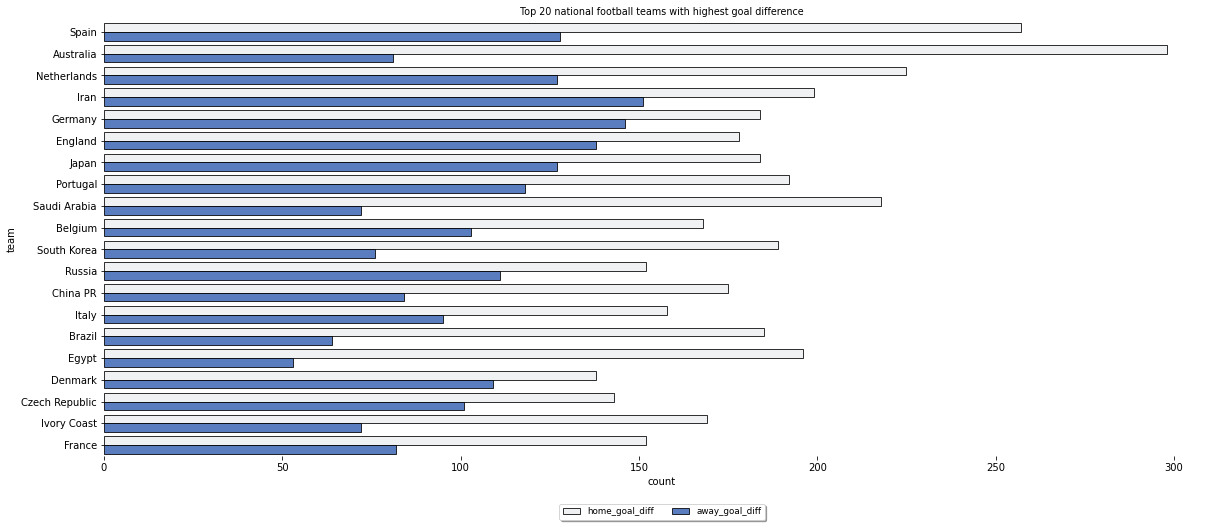

In [11]:
# Visualisation

# Process df for visualisation
df_vis = df_game_stat.sort_values(by=['total_goal_diff'], ascending=False).head(20)
df_vis = df_vis[['team', 'home_goal_diff', 'away_goal_diff']]
df_vis = df_vis.set_index('team').stack().reset_index()
df_vis.rename({'level_1': 'place', 0: 'count'}, axis=1, inplace=True)

f, ax = plt.subplots(figsize = (20,8))

sns.set_context('paper')

sns.set_color_codes('muted')
sns.barplot(x = 'count', y = 'team', hue = 'place',
           data = df_vis, color = 'b', edgecolor = 'black')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
sns.despine(left = True, bottom = True)
plt.title("Top 20 national football teams with highest goal difference")
plt.show()


In [12]:
# Show top 20 teams with most wins
df_game_stat.sort_values(by=['total_win'], ascending=False).head(20).reset_index(drop=True)

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,total_win,total_score,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
0,Spain,80,98,290,257,86,100,193,128,198,166,483,18,14,32,0.82,0.86,0.84,3.21,1.49,385,2.32
1,Italy,72,101,208,158,87,99,143,95,200,159,351,29,12,41,0.71,0.88,0.80,2.19,1.09,253,1.59
2,Portugal,71,100,240,192,81,98,178,118,198,152,418,29,17,46,0.71,0.83,0.77,2.70,1.46,310,2.04
3,Nigeria,78,103,206,162,66,84,97,58,187,144,303,25,18,43,0.76,0.79,0.77,2.08,0.88,220,1.53
4,Iran,64,95,237,199,79,93,202,151,188,143,439,31,14,45,0.67,0.85,0.76,3.11,1.91,350,2.45
5,Ivory Coast,68,99,228,169,75,98,122,72,197,143,350,31,23,54,0.69,0.77,0.73,2.49,0.96,241,1.69
6,Netherlands,75,99,266,225,66,88,177,127,187,141,443,24,22,46,0.76,0.75,0.75,3.00,1.92,352,2.50
7,England,65,93,221,178,75,87,179,138,180,140,400,28,12,40,0.70,0.86,0.78,2.74,1.84,316,2.26
8,Cameroon,76,115,196,145,63,82,111,65,197,139,307,39,19,58,0.66,0.77,0.71,1.91,1.03,210,1.51
9,Egypt,79,103,247,196,60,87,96,53,190,139,343,24,27,51,0.77,0.69,0.73,2.48,0.88,249,1.79


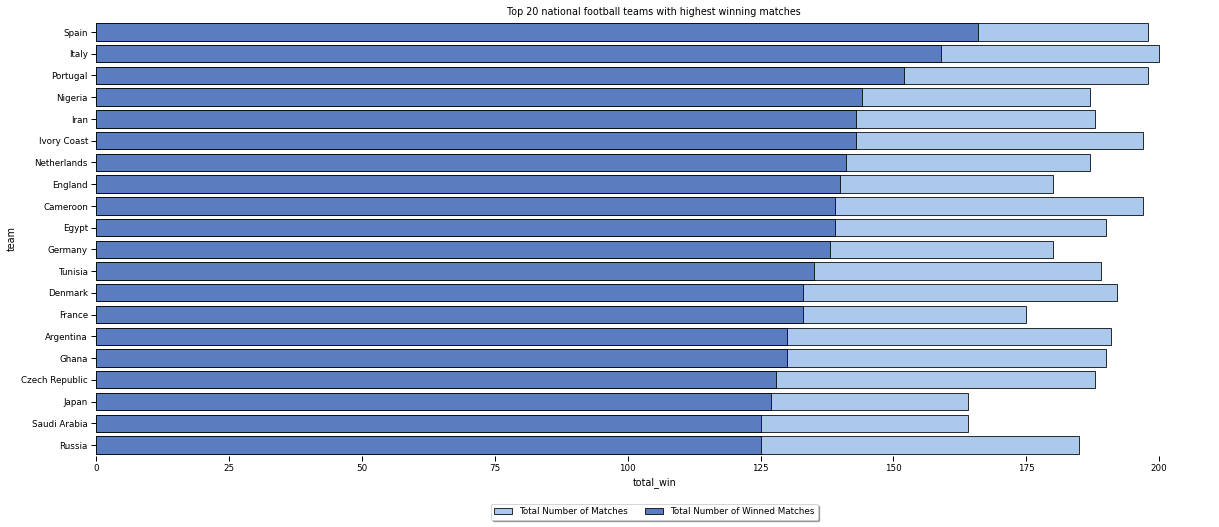

In [13]:
# Visualisation

df_vis = df_game_stat.sort_values(by=['total_win'], ascending=False).head(20)

sns.set_context('paper')

f, ax = plt.subplots(figsize = (20,8))

sns.set_color_codes('pastel')
sns.barplot(x = 'total_count', y = 'team', data = df_vis,
            label = 'Total Number of Matches', color = 'b', edgecolor = 'black')

sns.set_color_codes('muted')
sns.barplot(x = 'total_win', y = 'team', data = df_vis,
            label = 'Total Number of Winned Matches', color = 'b', edgecolor = 'black')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
sns.despine(left = True, bottom = True)
plt.title("Top 20 national football teams with highest winning matches")
plt.show()

In [14]:
# Show top 10 teams with highest win rate
df_game_stat.sort_values(by=['total_win_rate'], ascending=False).head(20).reset_index(drop=True)

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,total_win,total_score,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
0,Yugoslavia,3,4,16,13,4,4,8,8,8,7,24,1,0,1,0.75,1.00,0.88,4.33,2.00,21,3.00
1,Spain,80,98,290,257,86,100,193,128,198,166,483,18,14,32,0.82,0.86,0.84,3.21,1.49,385,2.32
2,Australia,72,88,334,298,47,61,107,81,149,119,441,16,14,30,0.82,0.77,0.80,4.14,1.72,379,3.18
3,Italy,72,101,208,158,87,99,143,95,200,159,351,29,12,41,0.71,0.88,0.80,2.19,1.09,253,1.59
4,England,65,93,221,178,75,87,179,138,180,140,400,28,12,40,0.70,0.86,0.78,2.74,1.84,316,2.26
5,Japan,59,84,228,184,68,80,166,127,164,127,394,25,12,37,0.70,0.85,0.77,3.12,1.87,311,2.45
6,Nigeria,78,103,206,162,66,84,97,58,187,144,303,25,18,43,0.76,0.79,0.77,2.08,0.88,220,1.53
7,Portugal,71,100,240,192,81,98,178,118,198,152,418,29,17,46,0.71,0.83,0.77,2.70,1.46,310,2.04
8,Germany,62,89,245,184,76,91,200,146,180,138,445,27,15,42,0.70,0.84,0.77,2.97,1.92,330,2.39
9,Saudi Arabia,72,94,258,218,53,70,108,72,164,125,366,22,17,39,0.77,0.76,0.76,3.03,1.36,290,2.32


### Player Analysis


In [115]:
df_player = pd.read_csv('E:\COM480-DataVis\datavis-project-2022-y3\Data\players_21_value.csv')
df_player.head()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\COM480-DataVis\\datavis-project-2022-y3\\Data\\players_21_value.csv'

In [16]:
list(df_player.columns)

['sofifa_id',
 'player_url',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agi

In [17]:
player_attr = ['sofifa_id','long_name','player_positions','overall','potential','value_eur','wage_eur','age','height_cm','weight_kg',
               'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'nationality_name', 'nation_position', 'nation_jersey_number',
               'preferred_foot', 'weak_foot', 'skill_moves', 'body_type', 'real_face', 'player_tags', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
               'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
               'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
               'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
               'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
               'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
               'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
               'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']

df_player = df_player[player_attr]
df_player.head()

,sofifa_id,long_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_name,league_name,league_level,club_position,club_jersey_number,nationality_name,nation_position,nation_jersey_number,preferred_foot,weak_foot,...,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,158023,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,103500000.00,560000.00,33,170,72,FC Barcelona,Spain Primera Division,1.00,CAM,10.00,Argentina,RW,10.00,Left,4,...,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8,NaN
1,20801,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",92,92,63000000.00,220000.00,35,187,83,Juventus,Italian Serie A,1.00,LS,7.00,Portugal,LS,7.00,Right,4,...,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11,NaN
2,188545,Robert Lewandowski,ST,91,91,111000000.00,240000.00,31,184,80,FC Bayern München,German 1. Bundesliga,1.00,ST,9.00,Poland,NaN,NaN,Right,4,...,89,84,76,86,85,81,49,94,79,88,88,35,42,19,15,6,12,8,10,NaN
3,190871,Neymar da Silva Santos Júnior,"LW, CAM",91,91,132000000.00,270000.00,28,175,68,Paris Saint-Germain,French Ligue 1,1.00,LW,10.00,Brazil,NaN,NaN,Right,5,...,80,62,81,50,84,51,36,87,90,92,93,35,30,29,9,9,15,15,11,NaN
4,192985,Kevin De Bruyne,"CAM, CM",91,91,129000000.00,370000.00,29,181,70,Manchester City,English Premier League,1.00,RCM,17.00,Belgium,RCM,7.00,Right,5,...,91,63,89,74,91,76,66,88,94,84,91,68,65,53,15,13,5,10,13,NaN


In [18]:
# Drop players where value_eur or wage_eur is missing
df_player = df_player.dropna(subset=['value_eur', 'wage_eur'])

In [19]:
# Filter nation with more than 20 registered players (number of players in the national squad)
df_player = df_player.groupby('nationality_name').filter(lambda x: x['nationality_name'].shape[0] > 20)

In [20]:
d_player_value_wage = df_player.groupby('nationality_name').describe()[['value_eur','wage_eur']]
d_player_value_wage.columns = d_player_value_wage.columns.get_level_values(0) + '_' + d_player_value_wage.columns.get_level_values(1)

In [21]:
# Dispay top 40 countries statistics by count of registered players
d_nation_top_count = d_player_value_wage.sort_values(by=['value_eur_count'], ascending=False).head(20)
d_nation_top_count

,value_eur_count,value_eur_mean,value_eur_std,value_eur_min,value_eur_25%,value_eur_50%,value_eur_75%,value_eur_max,wage_eur_count,wage_eur_mean,wage_eur_std,wage_eur_min,wage_eur_25%,wage_eur_50%,wage_eur_75%,wage_eur_max
nationality_name,,,,,,,,,,,,,,,,
England,1683.00,2304447.42,7785459.69,25000.00,325000.00,600000.00,1400000.00,124000000.00,1683.00,9622.10,19388.86,500.00,2000.00,3000.00,7000.00,270000.00
Germany,1189.00,3018292.68,9138420.96,15000.00,550000.00,975000.00,1900000.00,121000000.00,1189.00,9141.38,20156.54,500.00,1000.00,3000.00,8000.00,310000.00
Spain,1071.00,5237338.94,9543119.44,60000.00,925000.00,1700000.00,4100000.00,66500000.00,1071.00,14963.59,27094.08,500.00,3000.00,6000.00,18000.00,300000.00
France,984.00,4761519.31,11746459.16,35000.00,600000.00,1200000.00,3000000.00,185500000.00,984.00,13652.39,27923.96,500.00,2000.00,4000.00,15000.00,350000.00
Argentina,936.00,3453344.02,8488579.50,50000.00,600000.00,1300000.00,2800000.00,109000000.00,936.00,10005.02,25542.22,500.00,2000.00,4000.00,11000.00,560000.00
Brazil,884.00,5575113.12,11358419.07,50000.00,1100000.00,1900000.00,4300000.00,132000000.00,884.00,16683.31,26678.13,500.00,4000.00,9000.00,19000.00,310000.00
Japan,486.00,1113631.69,1542665.96,35000.00,406250.00,775000.00,1300000.00,14000000.00,486.00,3750.62,6403.56,500.00,1000.00,2000.00,4000.00,79000.00
Netherlands,432.00,4270011.57,10823959.64,80000.00,675000.00,1200000.00,2900000.00,113000000.00,432.00,11046.30,22381.63,500.00,2000.00,4000.00,11000.00,210000.00
Italy,421.00,4748040.38,9736905.98,45000.00,775000.00,1600000.00,3400000.00,93500000.00,421.00,15142.16,21674.06,500.00,2000.00,6000.00,18000.00,135000.00


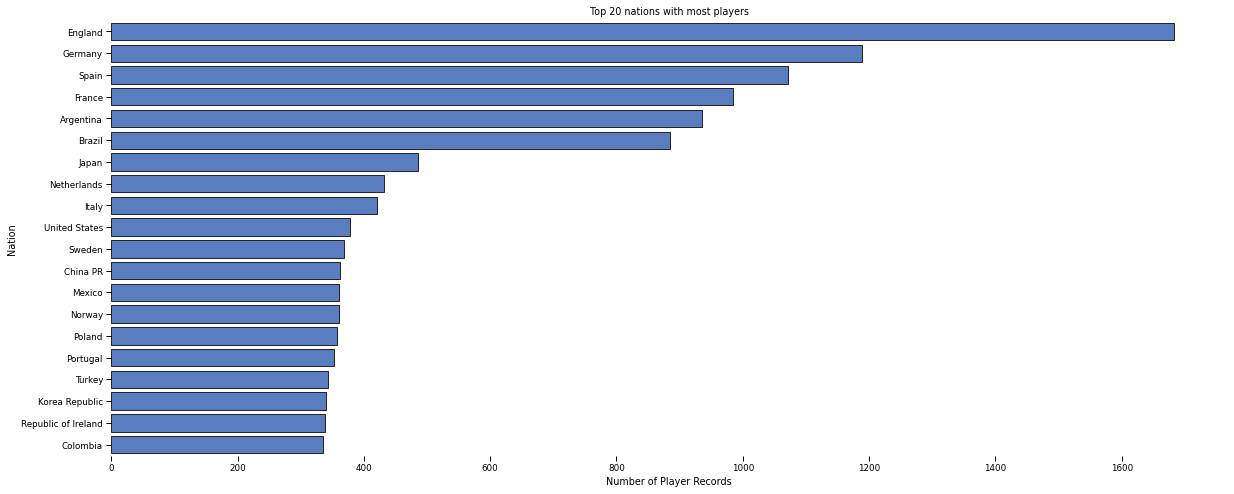

In [22]:
# Visualisation

f, ax = plt.subplots(figsize = (20,8))

sns.set_context('paper')

sns.set_color_codes('muted')
sns.barplot(x = 'value_eur_count', y = 'nationality_name',
           data = d_nation_top_count.reset_index(), color = 'b', edgecolor = 'black')

sns.despine(left = True, bottom = True)
plt.title("Top 20 nations with most players")
plt.xlabel("Number of Player Records")
plt.ylabel("Nation")
plt.show()

In [ ]:
# Dispay top 20 countries statistics by registered player's value and wage  
d_nation_top_value = d_player_value_wage.sort_values(by=['value_eur_mean', 'wage_eur_mean'], ascending=False).head(20)
d_nation_top_value

,value_eur_count,value_eur_mean,value_eur_std,value_eur_min,value_eur_25%,value_eur_50%,value_eur_75%,value_eur_max,wage_eur_count,wage_eur_mean,wage_eur_std,wage_eur_min,wage_eur_25%,wage_eur_50%,wage_eur_75%,wage_eur_max
nationality_name,,,,,,,,,,,,,,,,
Portugal,353.00,6137577.90,12123955.28,100000.00,925000.00,1800000.00,5000000.00,105500000.00,353.00,14238.10,28521.64,500.00,2000.00,5000.00,13000.00,230000.00
Slovenia,45.00,6005555.56,18561823.06,250000.00,525000.00,1300000.00,2900000.00,120000000.00,45.00,14012.22,27639.27,550.00,2000.00,4000.00,10000.00,125000.00
Algeria,52.00,5789134.62,9070134.50,110000.00,937500.00,2400000.00,6250000.00,53000000.00,52.00,21576.92,32728.44,1000.00,5000.00,9500.00,27000.00,210000.00
Brazil,884.00,5575113.12,11358419.07,50000.00,1100000.00,1900000.00,4300000.00,132000000.00,884.00,16683.31,26678.13,500.00,4000.00,9000.00,19000.00,310000.00
Morocco,80.00,5286062.50,9972261.17,160000.00,1075000.00,1900000.00,4650000.00,62000000.00,80.00,15186.88,22083.56,600.00,3000.00,8500.00,17000.00,140000.00
Spain,1071.00,5237338.94,9543119.44,60000.00,925000.00,1700000.00,4100000.00,66500000.00,1071.00,14963.59,27094.08,500.00,3000.00,6000.00,18000.00,300000.00
Ukraine,65.00,5035692.31,6548560.90,170000.00,1400000.00,2400000.00,5500000.00,34000000.00,65.00,7129.23,15663.93,500.00,550.00,950.00,6000.00,95000.00
Croatia,132.00,5029924.24,8433926.20,250000.00,1000000.00,1650000.00,4200000.00,47000000.00,132.00,15164.39,30539.99,500.00,2000.00,5000.00,15250.00,260000.00
France,984.00,4761519.31,11746459.16,35000.00,600000.00,1200000.00,3000000.00,185500000.00,984.00,13652.39,27923.96,500.00,2000.00,4000.00,15000.00,350000.00


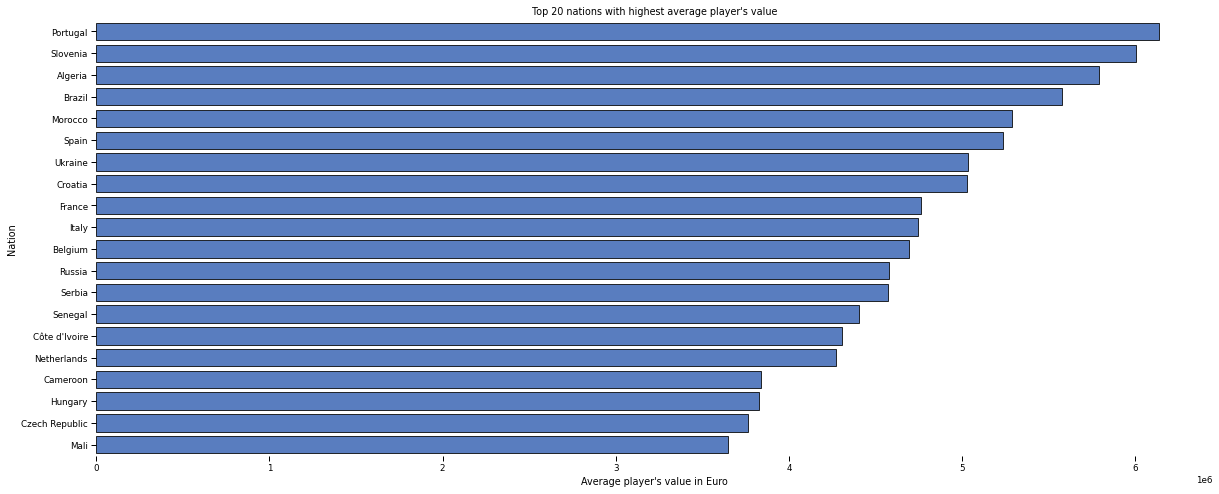

In [26]:
# Visualisation

f, ax = plt.subplots(figsize = (20,8))

sns.set_context('paper')

sns.set_color_codes('muted')
sns.barplot(x = 'value_eur_mean', y = 'nationality_name',
           data = d_nation_top_value.reset_index(), color = 'b', edgecolor = 'black')

sns.despine(left = True, bottom = True)
plt.title("Top 20 nations with highest average player's value")
plt.xlabel("Average player's value in Euro")
plt.ylabel("Nation")
plt.show()


**Discussion**: In this section we have done some shown some general analysis on the value and wage of registered players from countries with more than 20 players in the past 30 years. Moreover, we have also plotted some top statistics to see, e.g. countries with the highest number of football players and countries with the highest average value. Consequently, we have gained the following insights from the aforementioned statistics and visualisations:
- Top 20 countries with most players are all Eurpoean, Asian and South American countries. However, European and African took the vast majority among the top 20 countries with highest average value. African teams have showed their rising despite the total number of football players are lacking behind.
- England as the birthplace of the modern football, has an overwhelming amount of football players among all nations, followed by Germany, Spain, France, Argentina and Brazil, whose amount of players are more than twice of the 7th country Japan. Besides, these countries have also wonned the World Cup since 1986.
- **China** has a decent amount of football players (ranked 12th), but their players seems to be in a very unsatisfactory state to their nationals, which is also reflected by the mean player's value on the international transfer market. Nevertheless, this is not the real case as I can tell the Chinese football players is much much more expensive in the domestic transfer market, which will be further discussed and criticised in the following milestones.

### Generate files

In [135]:
df_player = pd.read_csv('./data/players_22_value.csv')
df_player.head()

/Users/xuyixuan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (25,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,...,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.00,320000.00,34,1987-06-24,170,72,73.00,Paris Saint-Germain,French Ligue 1,1.00,RW,30.00,NaN,...,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.00,270000.00,32,1988-08-21,185,81,21.00,FC Bayern München,German 1. Bundesliga,1.00,ST,9.00,NaN,...,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.00,270000.00,36,1985-02-05,187,83,11.00,Manchester United,English Premier League,1.00,ST,7.00,NaN,...,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.00,270000.00,29,1992-02-05,175,68,73.00,Paris Saint-Germain,French Ligue 1,1.00,LW,10.00,NaN,...,82+3,82+3,82+3,89+2,67+3,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.00,350000.00,30,1991-06-28,181,70,10.00,Manchester City,English Premier League,1.00,RCM,17.00,NaN,...,89+2,89+2,89+2,89+2,79+3,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png


In [149]:
countries = ['Argentina', 'Belgium', 'Brazil', 'Chile', 'Colombia', 'Croatia',
             'Denmark', 'France', 'Germany', 'Iceland', 'Italy', 'Japan',
             'Mexico', 'Netherlands', 'Nigeria', 'Poland', 'Portugal', 'Morocco',
             'Saudi Arabia', 'Senegal', 'Serbia', 'Korea Republic', 'Spain', 'Sweden', 
             'Switzerland', 'Turkey', 'England', 'United States', 'Uruguay', 'China PR']

In [150]:
df_filter = df_player[df_player.nationality_name.isin(countries)]
df_filter

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,...,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.00,320000.00,34,1987-06-24,170,72,73.00,Paris Saint-Germain,French Ligue 1,1.00,RW,30.00,NaN,...,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.00,270000.00,32,1988-08-21,185,81,21.00,FC Bayern München,German 1. Bundesliga,1.00,ST,9.00,NaN,...,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.00,270000.00,36,1985-02-05,187,83,11.00,Manchester United,English Premier League,1.00,ST,7.00,NaN,...,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.00,270000.00,29,1992-02-05,175,68,73.00,Paris Saint-Germain,French Ligue 1,1.00,LW,10.00,NaN,...,82+3,82+3,82+3,89+2,67+3,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.00,350000.00,30,1991-06-28,181,70,10.00,Manchester City,English Premier League,1.00,RCM,17.00,NaN,...,89+2,89+2,89+2,89+2,79+3,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19221,243790,https://sofifa.com/player/243790/zhenao-wang/2...,Wang Zhen'ao,王振澳,RW,47,57,110000.00,2000.00,21,1999-08-10,170,58,112378.00,Dalian Professional Football Club,Chinese Super League,1.00,SUB,34.00,NaN,...,41+2,41+2,41+2,46+2,40+2,36+2,36+2,36+2,40+2,39+2,35+2,35+2,35+2,39+2,14+2,https://cdn.sofifa.net/players/243/790/22_120.png,https://cdn.sofifa.net/teams/112378/60.png,https://cdn.sofifa.net/flags/cn.png,NaN,https://cdn.sofifa.net/flags/cn.png
19222,245024,https://sofifa.com/player/245024/shilong-wang/...,Wang Shilong,王世龙,CB,47,60,110000.00,2000.00,20,2001-03-07,177,64,111839.00,Guangzhou FC,Chinese Super League,1.00,SUB,20.00,NaN,...,33+2,33+2,33+2,34+2,45+2,42+2,42+2,42+2,45+2,47+2,47+2,47+2,47+2,47+2,13+2,https://cdn.sofifa.net/players/245/024/22_120.png,https://cdn.sofifa.net/teams/111839/60.png,https://cdn.sofifa.net/flags/cn.png,NaN,https://cdn.sofifa.net/flags/cn.png
19223,255615,https://sofifa.com/player/255615/xinfeng-fang/...,Fang Xinfeng,房欣峰,CDM,47,57,100000.00,1000.00,

In [151]:
attr = ['sofifa_id', 'short_name', 'overall', 'player_positions', 'value_eur', 'league_level', 'wage_eur', 'height_cm', 'weight_kg', 'club_name', 'nationality_name', 'real_face', 'player_face_url', 'shooting', 'passing', 'dribbling', 'defending', 
       'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
       'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']


df_filter = df_filter[attr]

In [152]:
df_filter = df_filter[df_filter.league_level == 1]

In [153]:
df_filter['attacking'] =  (df_filter['attacking_crossing'] + df_filter['attacking_finishing'] + df_filter['attacking_heading_accuracy'] + df_filter['attacking_short_passing'] + df_filter['attacking_volleys']) / 5

In [154]:
df_filter['skill'] =  (df_filter['skill_dribbling'] + df_filter['skill_curve'] + df_filter['skill_fk_accuracy'] + df_filter['skill_long_passing'] + df_filter['skill_ball_control']) / 5

In [155]:
df_filter['movement'] =  (df_filter['movement_acceleration'] + df_filter['movement_sprint_speed'] + df_filter['movement_agility'] + df_filter['movement_reactions'] + df_filter['movement_balance']) / 5

In [156]:
df_filter['power'] =  (df_filter['power_shot_power'] + df_filter['power_jumping'] + df_filter['power_stamina'] + df_filter['power_strength'] + df_filter['power_long_shots']) / 5

In [157]:
df_filter['defending'] =  (df_filter['defending_marking_awareness'] + df_filter['defending_standing_tackle'] + df_filter['defending_sliding_tackle']) / 3

In [158]:
df_filter['mentality'] =  (df_filter['mentality_aggression'] + df_filter['mentality_interceptions'] + df_filter['mentality_positioning'] + df_filter['mentality_penalties'] + df_filter['mentality_vision'] + df_filter['mentality_composure']) / 6

In [159]:
df_filter = df_filter[['sofifa_id', 'short_name', 'overall', 'player_positions', 'value_eur', 'league_level', 'wage_eur', 'height_cm', 'weight_kg', 'player_face_url',
                       'club_name', 'nationality_name', 'real_face', 'shooting', 'passing', 'dribbling', 'defending', 'attacking', 
                       'skill', 'movement', 'power', 'defending', 'mentality']]

In [160]:
df_filter

,sofifa_id,short_name,overall,player_positions,value_eur,league_level,wage_eur,height_cm,weight_kg,player_face_url,club_name,nationality_name,real_face,shooting,passing,dribbling,defending,attacking,skill,movement,power,defending,mentality
0,158023,L. Messi,93,"RW, ST, CF",78000000.00,1.00,320000.00,170,72,https://cdn.sofifa.net/players/158/023/22_120.png,Paris Saint-Germain,Argentina,Yes,92.00,91.00,95.00,26.33,85.80,94.00,90.20,77.80,26.33,73.83
1,188545,R. Lewandowski,92,ST,119500000.00,1.00,270000.00,185,81,https://cdn.sofifa.net/players/188/545/22_120.png,FC Bayern München,Poland,Yes,92.00,79.00,86.00,32.00,86.00,81.40,81.60,84.80,32.00,80.67
2,20801,Cristiano Ronaldo,91,"ST, LW",45000000.00,1.00,270000.00,187,83,https://cdn.sofifa.net/players/020/801/22_120.png,Manchester United,Portugal,Yes,94.00,80.00,88.00,26.67,87.60,83.60,85.40,87.20,26.67,74.33
3,190871,Neymar Jr,91,"LW, CAM",129000000.00,1.00,270000.00,175,68,https://cdn.sofifa.net/players/190/871/22_120.png,Paris Saint-Germain,Brazil,Yes,83.00,86.00,94.00,32.00,80.60,89.20,90.20,71.80,32.00,77.00
4,192985,K. De Bruyne,91,"CM, CAM",125500000.00,1.00,350000.00,181,70,https://cdn.sofifa.net/players/192/985/22_120.png,Manchester City,Belgium,Yes,86.00,93.00,88.00,62.00,81.40,88.00,80.00,81.60,62.00,82.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19221,243790,Wang Zhen'ao,47,RW,110000.00,1.00,2000.00,170,58,https://cdn.sofifa.net/players/243/790/22_120.png,Dalian Professional Football Club,China PR,No,49.00,41.00,48.00,33.33,43.00,38.80,50.80,47.00,33.33,39.67
19222,245024,Wang Shilong,47,CB,110000.00,1.00,2000.00,177,64,https://cdn.sofifa.net/players/245/024/22_120.png,Guangzhou FC,China PR,No,23.00,27.00,33.00,53.00,27.60,25.20,58.60,45.20,53.00,38.17
19223,255615,Fang Xinfeng,47,CDM,100000.00,1.00,1000.00,189,79,https://cdn.sofifa.net/players/255/615/22_120.png,Qingdao FC,China PR,No,31.00,43.00,44.00,44.00,36.60,41.80,56.00,45.20,44.00,41.50
19224,257687,Hu Xingyu,47,CM,100000.00,1.00,800.00,178,68,https://cdn.sofifa.net/players/257/687/22_120.png,Chongqing Liangjiang Athletic,China PR,No,33.00,47.00,45.00,40.00,38.40,40.80,60.20,49.20,40.00,43.67


In [161]:
df_filter.to_csv(r'./data/players.csv')

In [101]:
df_game = pd.read_csv('./Data/match_results.csv', 
                      parse_dates=['date'],
                      usecols=['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament'])
df_game.head()

,date,home_team,away_team,home_score,away_score,tournament
0,1872-11-30,Scotland,England,0,0,Friendly
1,1873-03-08,England,Scotland,4,2,Friendly
2,1874-03-07,Scotland,England,2,1,Friendly
3,1875-03-06,England,Scotland,2,2,Friendly
4,1876-03-04,Scotland,England,3,0,Friendly


In [102]:
# Filter data by year and tournament

# Only keep games from 2019
df_game = df_game[df_game.date.dt.year >= 2019]

# Only keep tournament that are methods of qualifaction for world cup, that is:
tournaments=['AFC Asian Cup', 'AFC Asian Cup qualification', 'African Cup of Nations', 'African Cup of Nations qualification', 'Copa América', 'Copa América qualification'
             'FIFA World Cup', 'FIFA World Cup qualification', 'Oceania Nations Cup', 'UEFA Euro', 'UEFA Euro qualification', 'UEFA Nations League', 'Friendly']

df_game = df_game[df_game.tournament.isin(tournaments)]
df_game.head()

,date,home_team,away_team,home_score,away_score,tournament
40566,2019-01-02,Oman,Thailand,2,0,Friendly
40567,2019-01-05,United Arab Emirates,Bahrain,1,1,AFC Asian Cup
40568,2019-01-06,Thailand,India,1,4,AFC Asian Cup
40569,2019-01-06,Australia,Jordan,0,1,AFC Asian Cup
40570,2019-01-06,Syria,Palestine,0,0,AFC Asian Cup


In [103]:
len(df_game)

2166

In [104]:
df_game.reset_index(drop=True, inplace=True)

In [105]:
df_game

,date,home_team,away_team,home_score,away_score,tournament
0,2019-01-02,Oman,Thailand,2,0,Friendly
1,2019-01-05,United Arab Emirates,Bahrain,1,1,AFC Asian Cup
2,2019-01-06,Thailand,India,1,4,AFC Asian Cup
3,2019-01-06,Australia,Jordan,0,1,AFC Asian Cup
4,2019-01-06,Syria,Palestine,0,0,AFC Asian Cup
...,...,...,...,...,...,...
2161,2022-02-01,Suriname,Guyana,2,1,Friendly
2162,2022-02-02,Burkina Faso,Senegal,1,3,African Cup of Nations
2163,2022-02-03,Cameroon,Egypt,0,0,African Cup of Nations
2164,2022-02-05,Cameroon,Burkina Faso,3,3,African Cup of Nations


In [106]:
df_game = df_game[df_game.home_score + df_game.away_score != 0]

In [ ]:
df_game['delta_goal'] = df_game['home_score'].astype(int) - df_game['away_score'].astype(int)

In [ ]:
df_game['win'] = df_game.apply(lambda x: 1 if x['delta_goal'] > 0 else 0, axis=1)

In [ ]:
df_game['lose'] = 1 - df_game['win']

In [110]:
df_game

,date,home_team,away_team,home_score,away_score,tournament,delta_goal,win,lose
0,2019-01-02,Oman,Thailand,2,0,Friendly,2,1,0
1,2019-01-05,United Arab Emirates,Bahrain,1,1,AFC Asian Cup,0,0,1
2,2019-01-06,Thailand,India,1,4,AFC Asian Cup,-3,0,1
3,2019-01-06,Australia,Jordan,0,1,AFC Asian Cup,-1,0,1
5,2019-01-07,China PR,Kyrgyzstan,2,1,AFC Asian Cup,1,1,0
...,...,...,...,...,...,...,...,...,...
2159,2022-02-01,Nepal,Mauritius,1,0,Friendly,1,1,0
2160,2022-02-01,Nicaragua,Belize,1,1,Friendly,0,0,1
2161,2022-02-01,Suriname,Guyana,2,1,Friendly,1,1,0
2162,2022-02-02,Burkina Faso,Senegal,1,3,African Cup of Nations,-2,0,1


In [113]:
df_game.to_csv(r'./data/matches_since2019.csv')

In [112]:
df_game.home_score.max()

15

In [114]:
df_game.home_team.unique()

array(['Oman', 'United Arab Emirates', 'Thailand', 'Australia',
       'China PR', 'South Korea', 'Iran', 'Finland', 'Iraq',
       'Saudi Arabia', 'Qatar', 'Japan', 'Uzbekistan', 'Bahrain',
       'Jordan', 'Estonia', 'Iceland', 'Palestine', 'Philippines',
       'Kyrgyzstan', 'Vietnam', 'Yemen', 'Lebanon', 'North Korea',
       'Turkmenistan', 'India', 'United States', 'Kazakhstan', 'Cuba',
       'Bolivia', 'Barbados', 'El Salvador', 'Cambodia', 'Bahamas',
       'Fiji', 'Solomon Islands', 'Germany', 'Wales', 'Kosovo',
       'Mauritius', 'Northern Ireland', 'Netherlands', 'Croatia',
       'Slovakia', 'Austria', 'North Macedonia', 'Israel', 'Cyprus',
       'Belgium', 'Argentina', 'Guatemala', 'Mexico', 'Peru', 'Bulgaria',
       'England', 'Luxembourg', 'Albania', 'Andorra', 'Moldova',
       'Botswana', 'Brazil', 'Malaysia', 'Georgia', 'Gibraltar', 'Malta',
       'Sweden', 'Spain', 'Bosnia and Herzegovina', 'Italy',
       'Liechtenstein', 'Senegal', 'Cameroon', 'Mali', 'Ghana',